## Загрузим нужные библиотеки

In [1]:
import re
import pickle
import imblearn

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import recall_score, roc_curve, roc_auc_score, \
    confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics._ranking import _binary_clf_curve
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

from tqdm.notebook import tqdm
from collections import Counter

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [2]:
import optuna

from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from catboost.metrics import Recall, AUC

from optuna.integration import LightGBMPruningCallback

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.kernel_approximation import Nystroem

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from scipy import sparse

In [4]:
df = pd.read_csv("content/train.csv", low_memory=False)
df_test = pd.read_csv('content/test.csv', low_memory=False)

## Преобразования данных

In [5]:
flag2int = {'N': 1, 'Y': 2, '0': 0}

for col in ['is_privatecategory', 'is_in_yandex', 'is_return']:
    df[col] = df[col].apply(lambda flag: flag2int[flag])

In [6]:
int_features = [
    'priority',
    'class',
    'mailtype',
    'mailctg',
    'mailrank',
    'directctg',
    'postmark',
    'is_wrong_sndr_name',
    'is_wrong_rcpn_name',
    'is_wrong_phone_number',
    'is_wrong_address',
] + [
    'weight', 'weight_mfi', 'price_mfi', 'dist_qty_oper_login_1', 'total_qty_oper_login_1',
    'total_qty_oper_login_0', 'total_qty_over_index_and_type', 'total_qty_over_index'
]

df[int_features] = df[int_features].astype(int)

In [7]:
df['index_oper'] = df['index_oper'].replace({'': '0', ' ': '0'}).astype(float).astype(int)

In [8]:
for col in ['is_privatecategory', 'is_in_yandex', 'is_return']:
    df_test[col] = df_test[col].apply(lambda flag: flag2int[flag])

df_test[int_features] = df_test[int_features].astype(int)

df_test['index_oper'] = df_test['index_oper'].replace({'': '0', ' ': '0'}).astype(float).astype(int)

## Рассмотрим датасет поближе

In [9]:
df.head()

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
0,6818780,1043_-1,628629,Участок,7503,1,0,2,1,87,...,42,720176,58950,779126,8290896,0,0,0,0,0
1,9907176,1023_-1,102976,ММПО,7503,1,0,1,1,107,...,914,48856658,83318932,132175590,136819803,0,0,0,0,0
2,3304275,1018_-1,620962,Цех,7503,1,0,2,1,50,...,62,3246292,3233068,6479360,52708071,0,1,0,0,0
3,9020937,1019_-1,344964,Цех,7503,1,0,2,1,416,...,55,2060928,653280,2714208,19562334,0,0,0,0,0
4,3082311,1020_-1,629819,Участок,7503,1,0,2,1,795,...,16,316919,27911,344830,4719186,0,0,0,0,0


In [10]:
object_features = [
    'index_oper',
    'type',
    'priority',
    'is_privatecategory',
    'class',
    'is_in_yandex'
]

mail_features = [
    'weight',
    'mailtype',
    'mailctg',
    'mailrank',
    'directctg',
    'name_mfi',
    'weight_mfi',
    'price_mfi',
    'is_wrong_sndr_name',
    'is_wrong_rcpn_name',
    'is_wrong_phone_number',
    'is_wrong_address'
]

object_mail_features = [
    'is_return',
    'transport_pay',
    'postmark',
    'dist_qty_oper_login_1',
    'total_qty_oper_login_1',
    'total_qty_oper_login_0',
    'total_qty_over_index_and_type',
    'total_qty_over_index'
]

operation_features = [
    'id',
    'oper_type + oper_attr'
]

Поcтроим матрицу корреляции значений

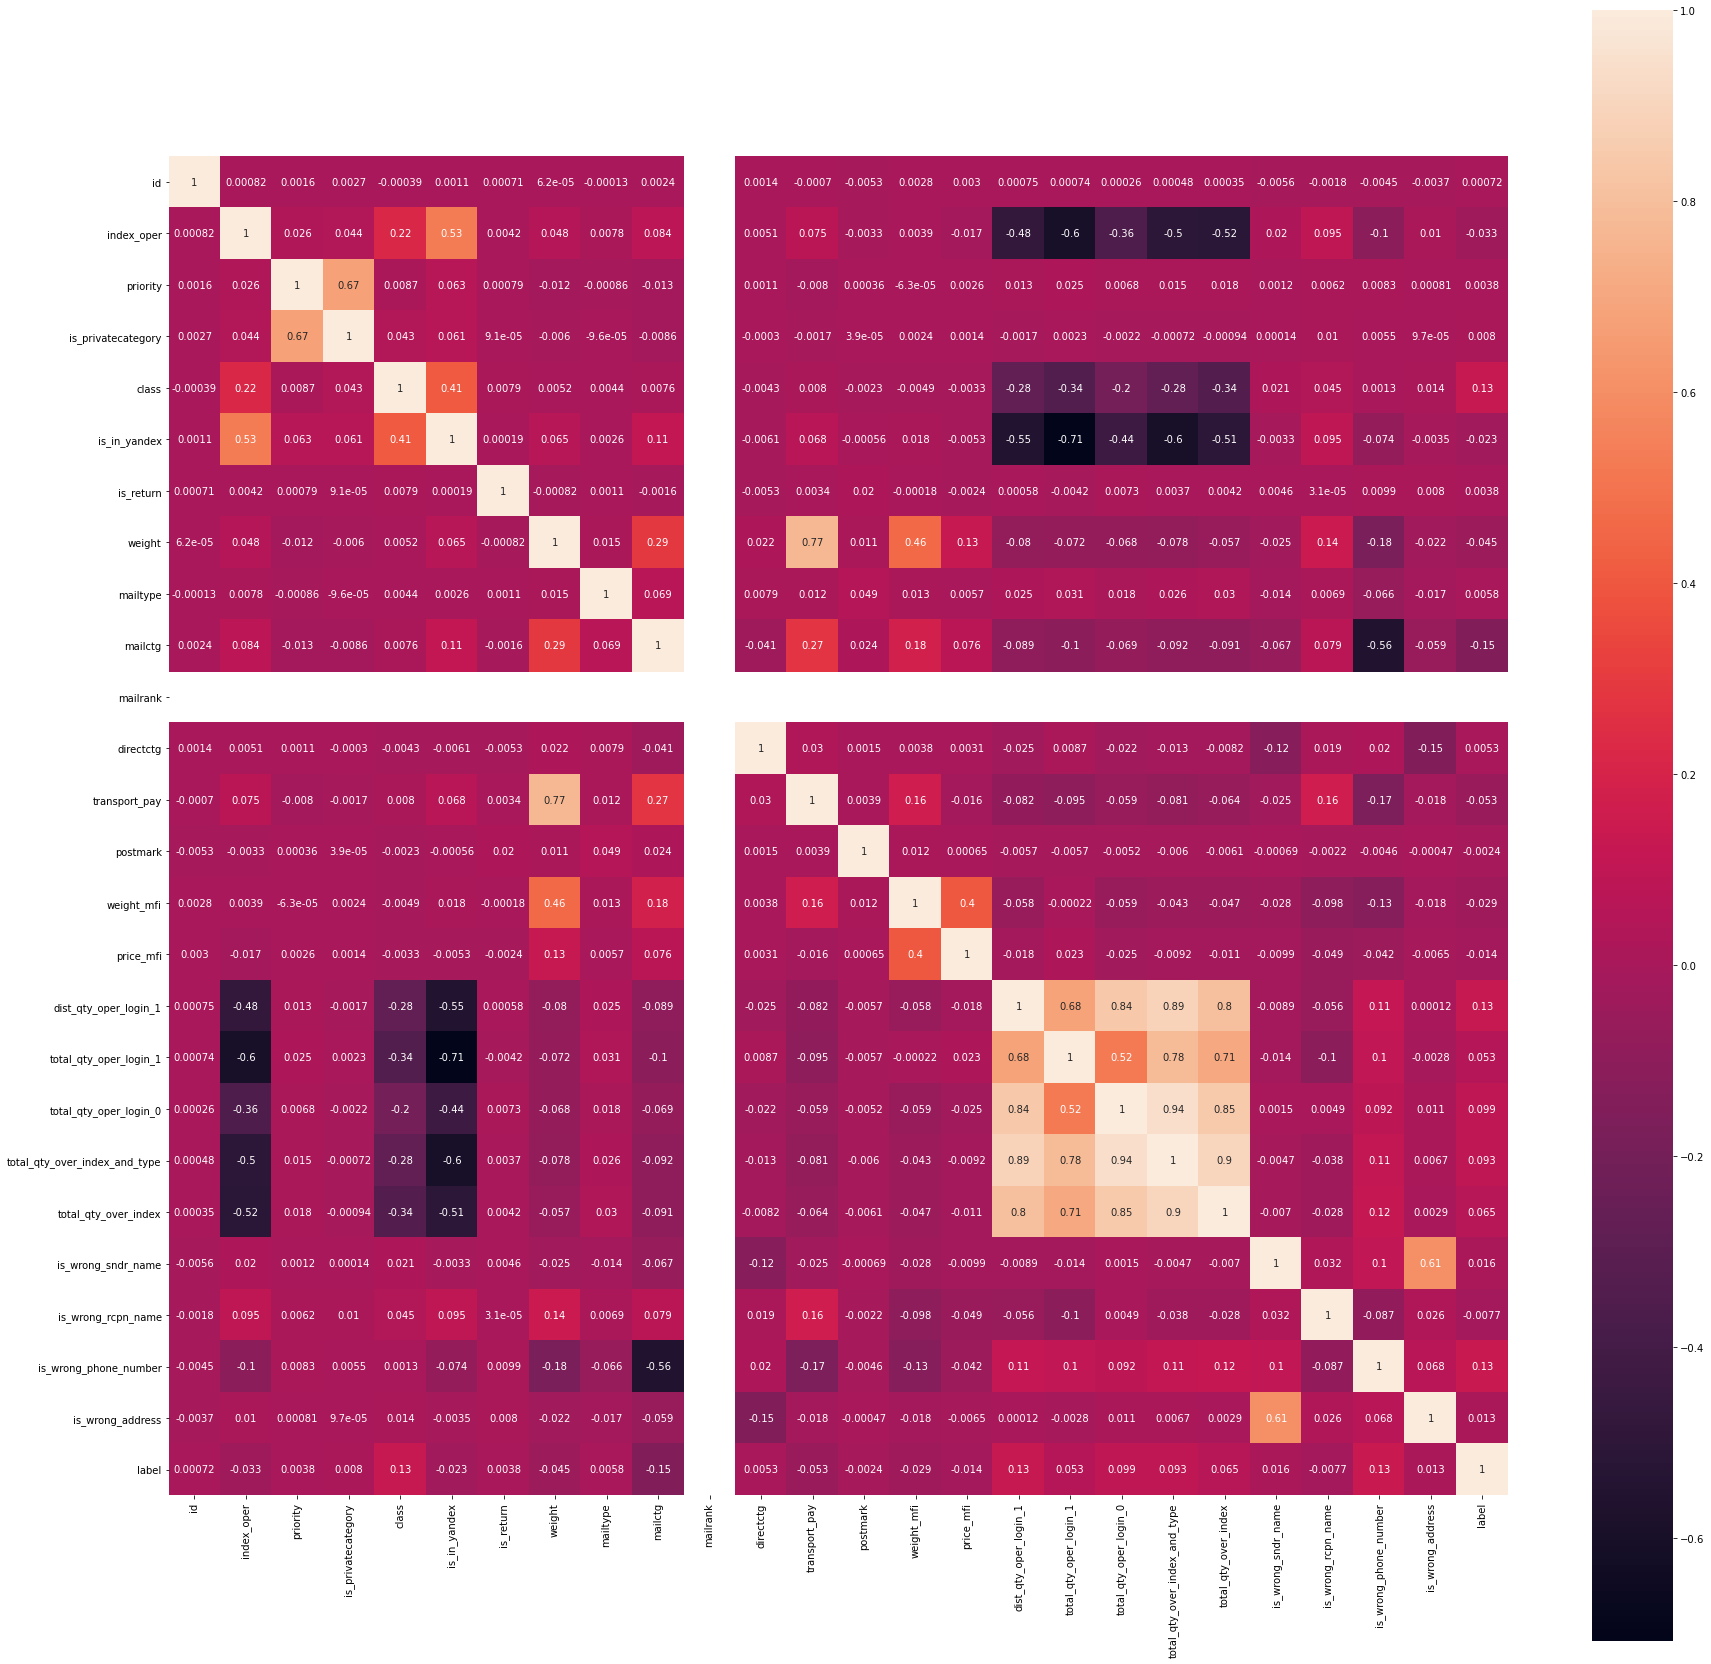

In [61]:
plt.rcParams['figure.figsize'] = (30, 30)

corr = df.iloc[:100000].corr()
g = sns.heatmap(corr, square = True, annot=True)

plt.rcParams['figure.figsize'] = (10, 5)

## Ислледование данных

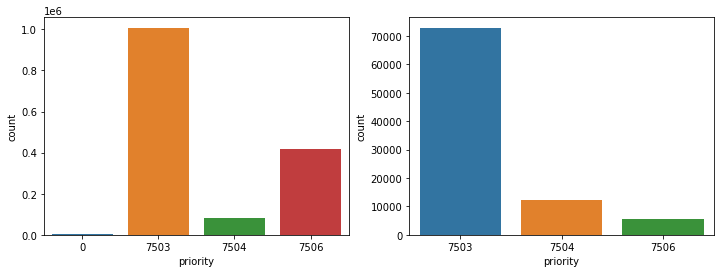

Counter({7503: 1007732, 7506: 417854, 7504: 80620, 0: 3016}) 



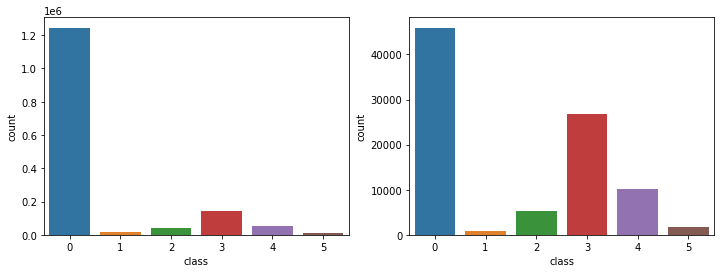

Counter({0: 1244488, 3: 145881, 4: 54676, 2: 39116, 1: 16724, 5: 8337}) 



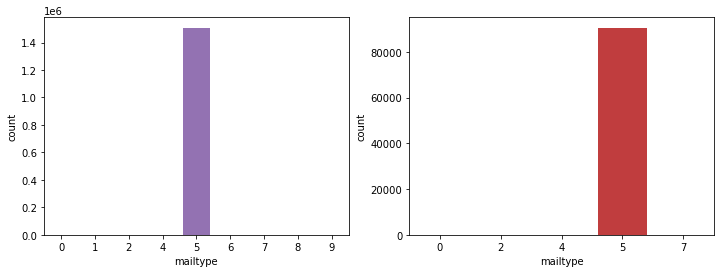

Counter({5: 1507977, 0: 770, 2: 316, 7: 116, 4: 28, 1: 6, 8: 5, 6: 2, 9: 2}) 



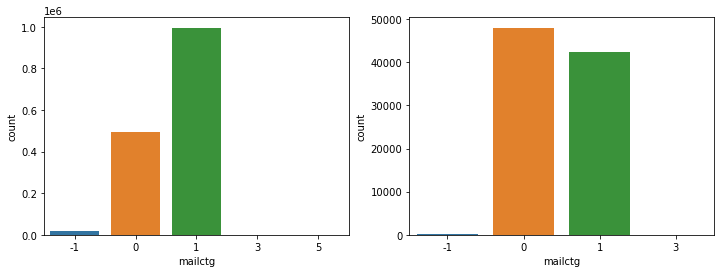

Counter({1: 996144, 0: 494383, -1: 18545, 3: 144, 5: 6}) 



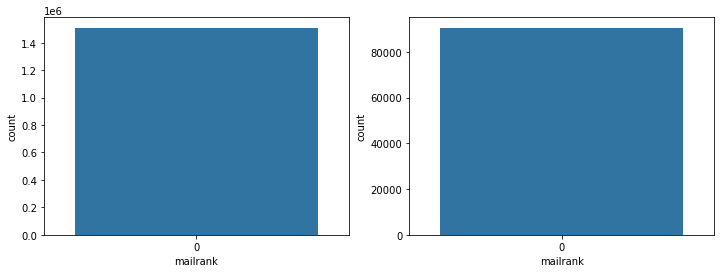

Counter({0: 1509222}) 



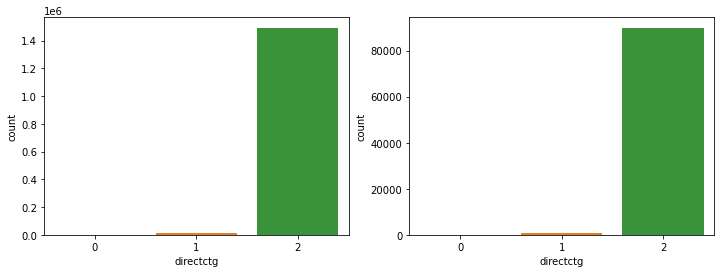

Counter({2: 1493096, 1: 16103, 0: 23}) 



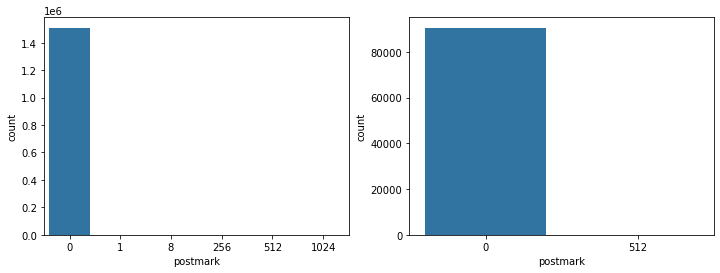

Counter({0: 1508973, 512: 218, 1024: 21, 8: 6, 256: 2, 1: 2}) 



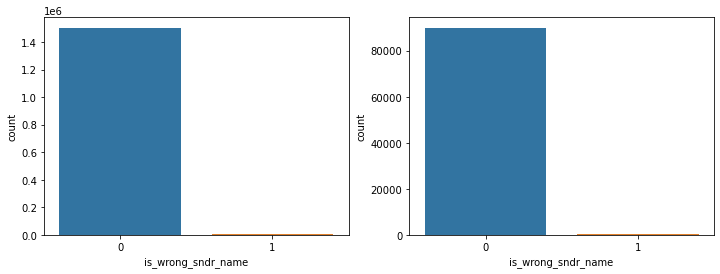

Counter({0: 1504114, 1: 5108}) 



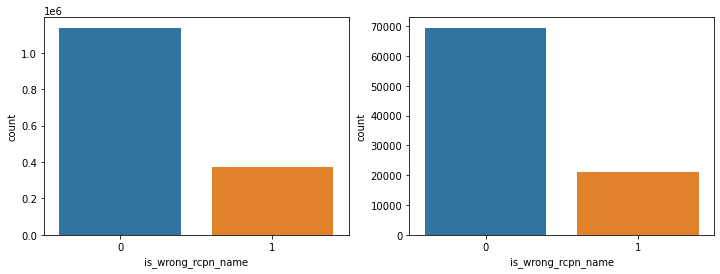

Counter({0: 1137212, 1: 372010}) 



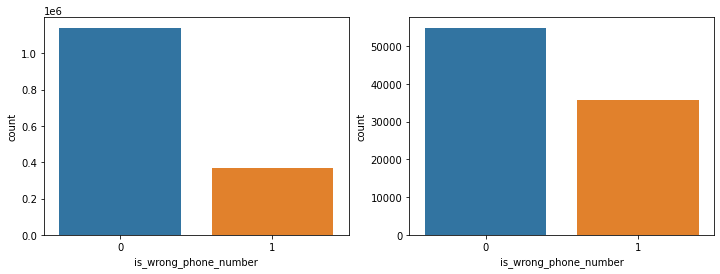

Counter({0: 1141220, 1: 368002}) 



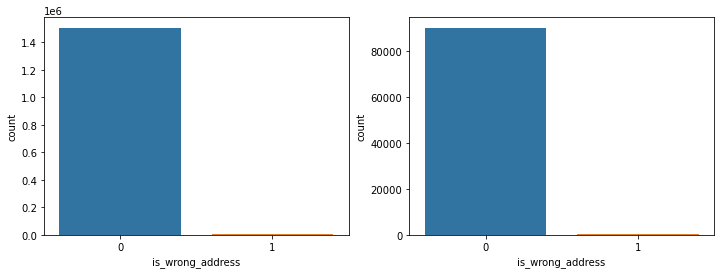

Counter({0: 1506274, 1: 2948}) 



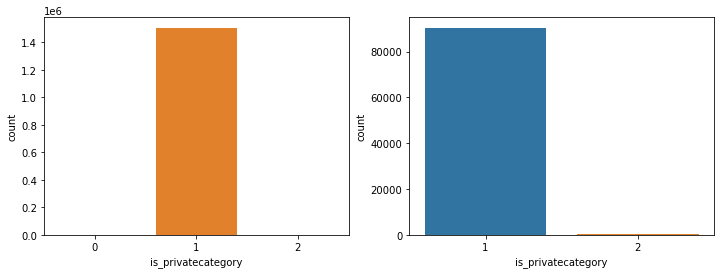

Counter({1: 1505533, 0: 2541, 2: 1148}) 



In [293]:
count_features = [
    'type',
    'priority',
    'class',
    'mailtype',
    'mailctg',
    'mailrank',
    'directctg',
    'postmark',
    'is_wrong_sndr_name',
    'is_wrong_rcpn_name',
    'is_wrong_phone_number',
    'is_wrong_address',
    'is_privatecategory',
]

for feature in count_features:
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    sns.countplot(x=df[feature],ax=axs[0])
    sns.countplot(x=X_val[y_pred != y_val][feature], ax=axs[1])
#     sns.countplot(x=df_test[feature], ax=axs[1])
    plt.show()
    print(Counter(df[feature]), '\n')

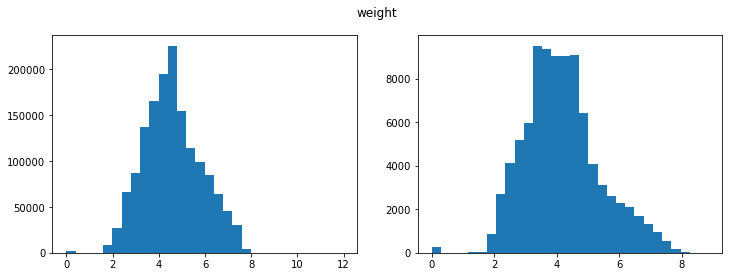

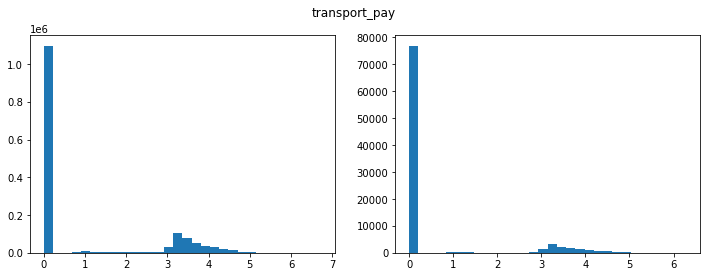

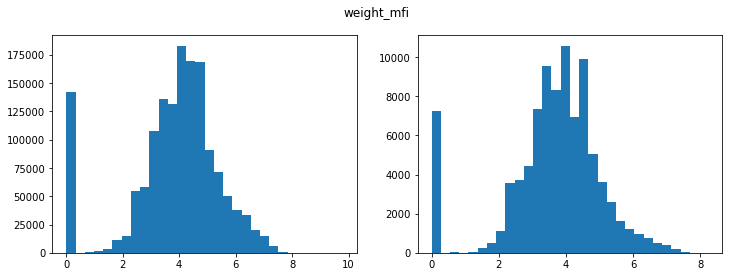

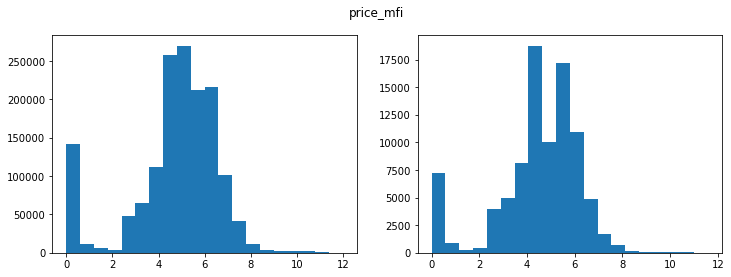

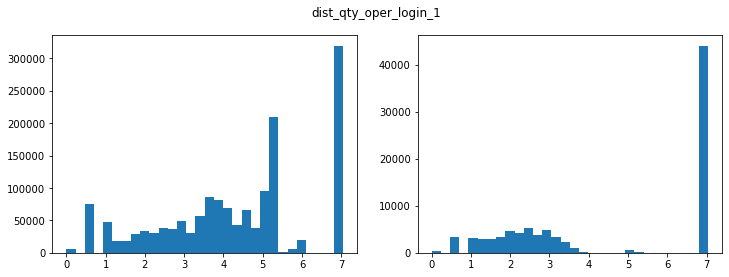

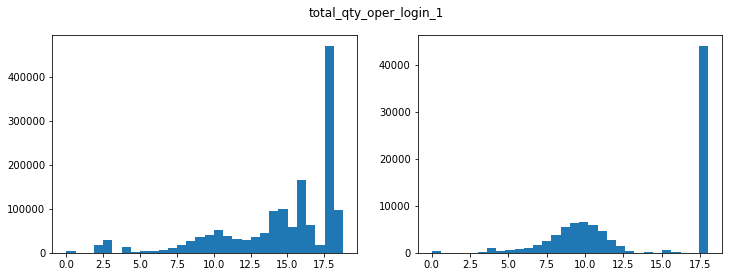

In [294]:
float_features = [
    'weight',
    'transport_pay',
    'weight_mfi',
    'price_mfi',
    'dist_qty_oper_login_1',
    'total_qty_oper_login_1'
]

features_bins = [
    30,
    30,
    30,
    20,
    30,
    30
]


for feature, bins in zip(float_features, features_bins):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    fig.suptitle(feature)
    axs[0].hist(np.log(df[feature] + 1), bins)
    axs[1].hist(np.log(X_val[y_pred != y_val][feature] + 1), bins)
#     axs[1].hist(np.log(df_test[feature] + 1), bins)


#     axs[0].hist(df[feature], bins)
#     axs[1].hist(df_test[feature], bins)

    plt.show()

## Преобразования данных

In [11]:
df['test'] = False
df_test['test'] = True

df_merged = pd.concat([df, df_test])
df_merged['one'] = 1

groupby = df_merged.groupby(df_merged.columns.drop(operation_features + ['test', 'label']).to_list())
df_merged['num_oper'] = groupby['one'].transform('sum')

df = df_merged[df_merged['test'] == False].drop(columns=['one', 'test'])
df_test = df_merged[df_merged['test'] == True].drop(columns=['one', 'test', 'label'])

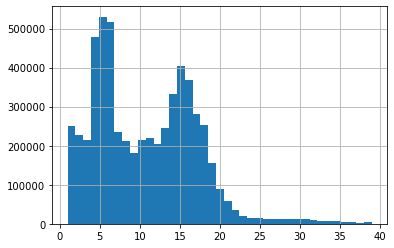

In [12]:
df[df['num_oper'] < 40]['num_oper'].hist(bins=39);

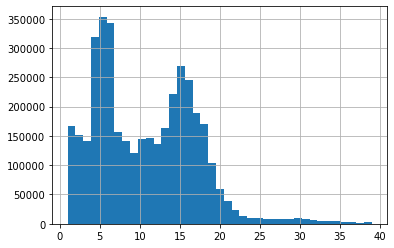

In [13]:
df_test[df_test['num_oper'] < 40]['num_oper'].hist(bins=39);

In [14]:
print(f'Df train shape: {df.shape}\nDf test shape:  {df_test.shape}')

Df train shape: (6000000, 30)
Df test shape:  (4000000, 29)


In [15]:
df = df.drop(operation_features, axis=1)
df_test = df_test.drop(operation_features, axis=1)

In [16]:
df['name_mfi'].nunique()

212936

In [17]:
def process_name_mfi(name_mfi):
    name_mfi = name_mfi.lower()
    name_mfi = ' '.join([w for w in name_mfi.split(' ') if w.isalpha()])
    return name_mfi

In [18]:
df['name_mfi'] = df['name_mfi'].apply(process_name_mfi)
df_test['name_mfi'] = df_test['name_mfi'].apply(process_name_mfi)

In [19]:
df['name_mfi'].nunique()

76976

In [20]:
df_train, df_val = train_test_split(df, test_size=0.1, random_state=42)

In [21]:
X_train = df_train.drop(columns=['label'])
y_train = df_train["label"]

X_val = df_val.drop(columns=['label'])
y_val = df_val["label"]

In [22]:
print(f'X_train.shape = {X_train.shape}')

X_train.shape = (5400000, 27)


## Обучение модели

In [23]:
def result_metric(y_true, y_pred):
    recall = recall_score(y_true, y_pred, average='macro')
    auc = roc_auc_score(y_true,  y_pred, multi_class='ovo')
    return 0.1 * recall + 0.9 * auc

In [24]:
class DropTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_features):
        self.drop_features = drop_features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.drop(columns=self.drop_features)

In [ ]:
def objective(trial):
    param_grid = {
        "objective": "binary",
        "class_weight": "balanced",
        "random_state": 42,
        "n_jobs": -1,
        "verbosity": -1,
        
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt"]),
        "n_estimators": trial.suggest_categorical("n_estimators", [150]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 50000, step=100),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.1, 1.0, step=0.05
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.1, 1.0, step=0.05
        ),
    }
    
    transformer = DropTransformer(['type', 'name_mfi'])
    X_train_lgbm = transformer.fit_transform(X_train)
    X_val_lgbm = transformer.transform(X_val)
    
    model = LGBMClassifier(
        **param_grid
    )
    
    model.fit(
        X_train_lgbm,
        y_train,
        eval_set=[(X_val_lgbm, y_val)],
        eval_metric="binary_logloss",
        early_stopping_rounds=30,
        callbacks=[
            LightGBMPruningCallback(trial, "binary_logloss")
        ],
    )
    
    y_pred = model.predict(X_val_lgbm)
    
    # return model.best_score_['valid_0']['binary_logloss']
    return -result_metric(y_val, y_pred)


study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial)
study.optimize(func, n_trials=100)

In [53]:
print(f"\tBest value: {-study.best_value:.3f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): -0.92509
	Best params:
		boosting_type: gbdt
		n_estimators: 150
		learning_rate: 0.6572785960832688
		num_leaves: 660
		max_depth: 10
		min_data_in_leaf: 9500
		lambda_l2: 10
		min_gain_to_split: 1.6285705959802028
		bagging_fraction: 0.9500000000000001
		bagging_freq: 1
		feature_fraction: 0.9


In [30]:
# lgbm_best_params = study.best_params

lgbm_best_params = {
    'boosting_type': 'gbdt',
    'n_estimators': 150,
    'learning_rate': 0.6572785960832688,
    'num_leaves': 660,
    'max_depth': 10,
    'min_data_in_leaf': 9500,
    'lambda_l2': 10,
    'min_gain_to_split': 1.6285705959802028,
    'bagging_fraction': 0.9500000000000001,
    'bagging_freq': 1,
    'feature_fraction': 0.9
}

In [ ]:
clf = LGBMClassifier(
    objective='binary',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    **lgbm_best_params
)

clf.fit(X_train, y_train, eval_set=(X_val, y_val))

In [81]:
# clf = RandomForestClassifier(random_state=0)

catboost_clf = CatBoostClassifier(
    n_estimators=50,
    cat_features=cat_features,
    text_features=text_features,
    embedding_features=embedding_features,
    class_weights={0: positive_rate, 1: negative_rate},
    custom_metric=AUC(),
    random_seed=42
)

In [82]:
catboost_clf.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val),
    plot=True,
    verbose=True,
    use_best_model=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.5
0:	learn: 0.3061102	test: 0.2959087	best: 0.2959087 (0)	total: 2.42s	remaining: 1m 58s
1:	learn: 0.2337845	test: 0.2256718	best: 0.2256718 (1)	total: 4.38s	remaining: 1m 45s
2:	learn: 0.2152293	test: 0.2108010	best: 0.2108010 (2)	total: 8.39s	remaining: 2m 11s
3:	learn: 0.2078755	test: 0.2040231	best: 0.2040231 (3)	total: 10.9s	remaining: 2m 5s
4:	learn: 0.2026198	test: 0.1993160	best: 0.1993160 (4)	total: 12.6s	remaining: 1m 53s
5:	learn: 0.1999189	test: 0.1966677	best: 0.1966677 (5)	total: 14.5s	remaining: 1m 46s
6:	learn: 0.1941090	test: 0.1914141	best: 0.1914141 (6)	total: 16.7s	remaining: 1m 42s
7:	learn: 0.1926802	test: 0.1902073	best: 0.1902073 (7)	total: 18.8s	remaining: 1m 38s
8:	learn: 0.1916638	test: 0.1891785	best: 0.1891785 (8)	total: 23.2s	remaining: 1m 45s
9:	learn: 0.1899019	test: 0.1874946	best: 0.1874946 (9)	total: 24.8s	remaining: 1m 39s
10:	learn: 0.1891170	test: 0.1868628	best: 0.1868628 (10)	total: 26.5s	remaining: 1m 33s
11:	learn: 0.1864

In [106]:
# clf.select_features(
#     X_train,
#     y=y_train,
#     eval_set=(X_val, y_val),
#     features_for_select=X_train.columns,
#     num_features_to_select=len(X_train.columns) - 10,
# #     algorithm=None,
# #     steps=None,
# #     shap_calc_type=None,
#     train_final_model=False,
#     verbose=False,
# #     logging_level=None,
#     plot=True
# )

In [107]:
# output = clf.get_object_importance(
#     pool=Pool(data=X_val[:len(X_val) // 100], label=y_val[:len(X_val) // 100], cat_features=cat_features),
#     train_pool=Pool(data=X_train[:len(X_train) // 100], label=y_train[:len(X_train) // 100], cat_features=cat_features),
#     top_size=-1,
#     type='Average',
#     update_method='SinglePoint',
#     importance_values_sign='All',
#     thread_count=-1,
#     verbose=True
# )

In [108]:
# plt.hist(output[1], bins=20);

In [83]:
catboost_clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,type,22.832913
1,index_oper,17.742824
2,num_oper,15.460994
3,total_qty_oper_login_0,9.312172
4,total_qty_oper_login_1,8.317075
5,total_qty_over_index,7.093347
6,mailctg,4.864027
7,dist_qty_oper_login_1,3.564466
8,transport_pay,2.514497
9,total_qty_over_index_and_type,2.139504


In [110]:
# clf.calc_feature_statistics(
#     data=X_val,
#     target=y_val,
# #     feature=clf.get_feature_importance(prettified=True)['Feature Id'].values[1:],
# #     feature=['mailctg'],
#     prediction_type='Probability'
# );

## Stacking

In [25]:
X_test = df_test.copy()

In [26]:
class NumTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cat_features = [
            'priority', 'class', 'mailctg', 'mailrank', 'directctg', 'is_privatecategory',
            'is_in_yandex',  'postmark', 'mailtype',
        ]
        
        self.exp_features = [
            'weight', 'transport_pay', 'num_oper', 'total_qty_over_index'
        ]
        
        self.ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        self.scaler = StandardScaler()
    
    def process_num(self, X, y=None):
        X_num = X.drop(columns=self.cat_features)
        
        for col in X_num.columns:
            X_num[f'{col}_missing'] = (X_num[col] == 0)
        
        for col in self.exp_features:
            X_num[col] = np.log(1 + X_num[col])
        
        return X_num

    def fit(self, X, y=None):
        X_num = self.process_num(X)
        
        for col in self.exp_features:
            X_num[col] = np.log(1 + X_num[col])
            
        self.scaler.fit(X_num)
        self.ohe.fit(X[self.cat_features])
        
        return self

    def transform(self, X, y=None):
        X_num = self.process_num(X)
        
        X_num = pd.DataFrame(self.scaler.transform(X_num), columns=X_num.columns)
        X_ohe = pd.DataFrame(
            self.ohe.transform(X[self.cat_features]),
            columns=self.ohe.get_feature_names_out()
        )
        
        return pd.concat([X_num, X_ohe], axis=1)

In [27]:
def select_rows(X, y, select_part):
    select_num = int(len(X) * select_part)
    return X[: select_num], y[: select_num]

In [38]:
estimators = [
    ('lr', imblearn.pipeline.make_pipeline(
        DropTransformer(['index_oper', 'type', 'name_mfi']),
        imblearn.FunctionSampler(func=select_rows, kw_args={'select_part': 0.1}),
        NumTransformer(),
        LogisticRegression(max_iter=5000, class_weight='balanced')
    )),
    ('cb', make_pipeline(
        CatBoostClassifier(
            n_estimators=175,
            cat_features=['type', 'name_mfi'],
            auto_class_weights='Balanced',
            verbose=True
        )
    )),
    ('lgbm', make_pipeline(
        DropTransformer(['type', 'name_mfi']),
        LGBMClassifier(
            objective='binary',
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            **lgbm_best_params
        )
    )),
]


clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(class_weight='balanced'),
    verbose=5,
    cv='prefit'
)

In [40]:
clf.named_estimators['lr'].fit(X_train, y_train)

Pipeline(steps=[('droptransformer',
                 DropTransformer(drop_features=['index_oper', 'type',
                                                'name_mfi'])),
                ('functionsampler',
                 FunctionSampler(func=<function select_rows at 0x0000024F13422E50>,
                                 kw_args={'select_part': 0.1})),
                ('numtransformer', NumTransformer()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=5000))])

In [39]:
clf.named_estimators['cb'].fit(X_train, y_train)

Learning rate set to 0.5
0:	learn: 0.2732875	total: 2.28s	remaining: 6m 37s
1:	learn: 0.2235074	total: 6.66s	remaining: 9m 35s
2:	learn: 0.2128413	total: 9.18s	remaining: 8m 46s
3:	learn: 0.2061828	total: 13.1s	remaining: 9m 21s
4:	learn: 0.1992656	total: 15.3s	remaining: 8m 39s
5:	learn: 0.1963319	total: 17.1s	remaining: 8m
6:	learn: 0.1946380	total: 19.1s	remaining: 7m 37s
7:	learn: 0.1913520	total: 21.1s	remaining: 7m 19s
8:	learn: 0.1893695	total: 25.6s	remaining: 7m 51s
9:	learn: 0.1874903	total: 27.5s	remaining: 7m 33s
10:	learn: 0.1859458	total: 29.4s	remaining: 7m 17s
11:	learn: 0.1854837	total: 31.2s	remaining: 7m 4s
12:	learn: 0.1846796	total: 33.8s	remaining: 7m 1s
13:	learn: 0.1840242	total: 38s	remaining: 7m 16s
14:	learn: 0.1835327	total: 40.1s	remaining: 7m 7s
15:	learn: 0.1826377	total: 44.5s	remaining: 7m 22s
16:	learn: 0.1823560	total: 46.7s	remaining: 7m 13s
17:	learn: 0.1817571	total: 48.7s	remaining: 7m 4s
18:	learn: 0.1813641	total: 53s	remaining: 7m 15s
19:	learn

Pipeline(steps=[('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x0000024F2B8636A0>)])

In [41]:
clf.named_estimators['lgbm'].fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=1.6285705959802028, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6285705959802028
[LightGBM] [Warning] bagging_fraction is set=0.9500000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9500000000000001
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Pipeline(steps=[('droptransformer',
                 DropTransformer(drop_features=['type', 'name_mfi'])),
                ('lgbmclassifier',
                 LGBMClassifier(bagging_fraction=0.9500000000000001,
                                bagging_freq=1, class_weight='balanced',
                                feature_fraction=0.9, lambda_l2=10,
                                learning_rate=0.6572785960832688, max_depth=10,
                                min_data_in_leaf=9500,
                                min_gain_to_split=1.6285705959802028,
                                n_estimators=150, num_leaves=660,
                                objective='binary', random_state=42))])

In [42]:
clf.fit(X_val, y_val)

StackingClassifier(cv='prefit',
                   estimators=[('lr',
                                Pipeline(steps=[('droptransformer',
                                                 DropTransformer(drop_features=['index_oper',
                                                                                'type',
                                                                                'name_mfi'])),
                                                ('functionsampler',
                                                 FunctionSampler(func=<function select_rows at 0x0000024F13422E50>,
                                                                 kw_args={'select_part': 0.1})),
                                                ('numtransformer',
                                                 NumTransformer()),
                                                ('logisticregression',
                                                 LogisticRegression(class_weight...
                                                 LGBMClassifier(bagging_fraction=0.9500000000000001,
                                                                bagging_freq=1,
                                                                class_weight='balanced',
                                                                feature_fraction=0.9,
                                                                lambda_l2=10,
                                                                learning_rate=0.6572785960832688,
                                                                max_depth=10,
                                                                min_data_in_leaf=9500,
                                                                min_gain_to_split=1.6285705959802028,
                                                                n_estimators=150,
                                                                num_leaves=660,
                                                                objective='binary',
                                                                random_state=42))]))],
                   final_estimator=LogisticRegression(class_weight='balanced'),
                   verbose=5)

In [43]:
y_pred_proba = clf.predict_proba(X_val)[:, 1]

In [44]:
fps, tps, thresholds = _binary_clf_curve(y_val, y_pred_proba)

ps = y_val.sum()
ns = (1 - y_val).sum()

fns = ps - tps
tns = ns - fps

tpr = tps / ps
fpr = fps / ns

recall = (tps / ps + tns / ns) / 2

best_threshold = thresholds[np.argmax(recall)]
y_pred = (y_pred_proba >= best_threshold).astype(int)

print(f'best_threshold = {best_threshold:.3f}')
print(f'Result score: {result_metric(y_val, y_pred):.6f}')

best_threshold = 0.410
Result score: 0.928849


In [45]:
# Full
# Catboost (100 iter)                                              0.9280 (lb - 0.8750)
# Catboost (100 iter) + Logreg                                     0.9281 (lb - 0.8750)
# Catboost (100 iter) + Logreg  + LGBM (150 iter)                  0.9288 (lb - 0.8789)

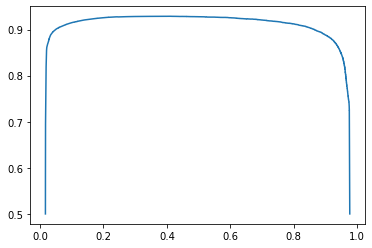

In [46]:
plt.plot(thresholds, recall);

In [47]:
clf.final_estimator_.coef_

array([[0.59031149, 4.90193723, 2.30213121]])

## Оценка точности

In [49]:
y_pred_proba = clf.predict_proba(X_val)[:, 1]

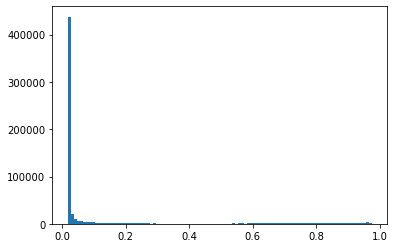

In [50]:
plt.hist(y_pred_proba[y_val == 0], bins=100);

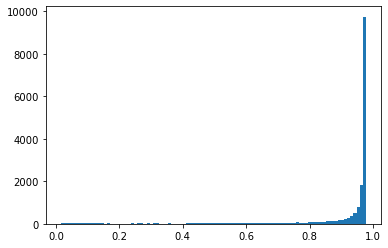

In [51]:
plt.hist(y_pred_proba[y_val == 1], bins=100);

$TP + FN = P$ (real $P$) \
$TN + FP = N$ (real $N$)

In [52]:
fps, tps, thresholds = _binary_clf_curve(y_val, y_pred_proba)

In [53]:
ps = y_val.sum()
ns = (1 - y_val).sum()

fns = ps - tps
tns = ns - fps

tpr = tps / ps
fpr = fps / ns

In [54]:
recall = (tps / ps + tns / ns) / 2

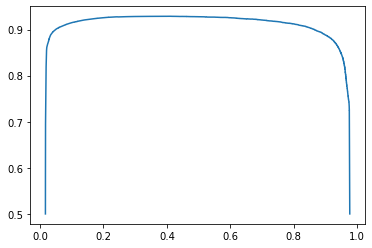

In [55]:
plt.plot(thresholds, recall);

In [56]:
auc = (1 + tpr - fpr) / 2

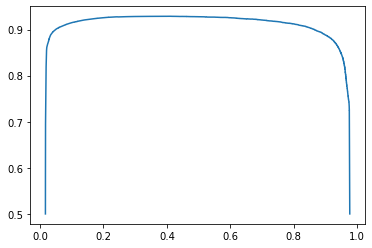

In [57]:
plt.plot(thresholds, auc);

In [58]:
score = 0.1 * recall + 0.9 * auc

In [59]:
best_threshold = thresholds[np.argmax(score)]
y_pred = (y_pred_proba >= best_threshold).astype(int)

print(f'best_score = {score.max():.6f}')
print(f'best_threshold = {best_threshold:.3f}')

best_score = 0.928849
best_threshold = 0.410


In [60]:
print(f'Mean y_val:  {y_val.mean():.6f}\nMean y_pred: {y_pred.mean():.6f}')

Mean y_val:  0.028797
Mean y_pred: 0.121625


TP = 16494
TN = 526241
FP = 56481
FN = 784


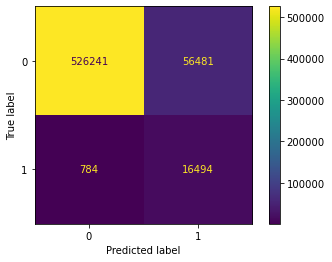

In [61]:
cm = confusion_matrix(y_val, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f'TP = {tp}\nTN = {tn}\nFP = {fp}\nFN = {fn}')
disp = ConfusionMatrixDisplay(cm)
disp.plot();

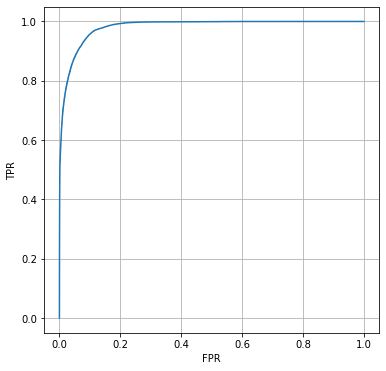

In [62]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()

In [63]:
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print(f'TPR = {tpr:.4f}\nFPR = {fpr:.4f}')

TPR = 0.9546
FPR = 0.0969


In [64]:
print(f'Result score: {result_metric(y_val, y_pred):.6f}')

Result score: 0.928849


## Итоговое предсказание

In [65]:
final_clf = clf
# X_test = df_test.copy()

In [75]:
# threshold = best_threshold  # ?
threshold = 0.05

In [76]:
# y_pred_proba = final_clf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= threshold).astype(int)

In [77]:
print(f'Mean y_pred: {y_pred.mean():.6f}')

Mean y_pred: 0.213094


In [81]:
solution = pd.read_csv('content/test.csv', low_memory=False)[['id']].copy()
solution['label'] = y_pred

In [82]:
solution.to_csv('solution.csv', index=False, lineterminator='\n')